In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

#from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import bootstrap_osi as osi
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/test_responsivity.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py",

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/combine_runs.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 6

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/target_visual_field.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application

In [2]:
%matplotlib notebook

In [3]:
def hist_roi_stat(gdf, metric='dff', roi_list=None, ax=None):
    if roi_list is None:
        roi_list = estats.gdf.groups.keys()
    if ax is None:
        fig, ax = pl.subplots()

    max_dffs_by_config = [gdf.get_group(roi).groupby(['config']).mean()['dff'].max() for roi in roi_list]
    sns.distplot(max_dffs_by_config, ax=ax)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    ax.set_ylabel('kde')
    return ax

# TEST GRATINGS:

In [206]:
rootdir = '/n/coxfs01/2p-data'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


# animalid = 'JC084' #'JC059'
# session = '20190522' #'20190227'

# animalid = 'JC097' #'JC059'
# session = '20190616' #'20190227'

animalid = 'JC083' #'JC059'
session = '20190512' #'20190227'



In [207]:
# renames = glob.glob(os.path.join(rootdir, 'JC*', '20*', '*zoom2p0x*', '*gratings*', 
#                                  'traces', 'traces001*', 'tuning', 'fit-dff_responsive-ROC-thr0.05_boot-100-resample-60',
#                                 '*bootstrap_params.json'))
# print(len(renames))

# for r in renames:
#     basedir = os.path.split(r)[0]
#     with open(r, 'r') as f:
#         params = json.load(f)
#     if params['directory'] != basedir:
#         params['directory'] = basedir
#         with open(r, 'w') as f:
#             json.dump(params, f, indent=4,)
        

# Create Experiment Obj

In [208]:
reload(util)
reload(osi)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_ins

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.pyc'>

# Test with 1 session

In [209]:
responsive_test='nstds'
responsive_thr=10.

In [210]:

exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
exp.print_info()

... [JC083|20190512|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: gratings
Animalid: JC083
Session: 20190512
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_0a550d_traces001_fa76b6_traces001_686258_traces001_2b2900_traces001_f43949/data_arrays/datasets.npz')
No data loaded yet.
**************************************************


In [211]:
roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, responsive_thr=responsive_thr)
print(len(roi_list))

... getting responsive cells (test: nstds, thr: 10.00')
256


In [212]:
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, add_offset=True)
#roi_list = estats.rois
print("Found %i responsive cells (%s, thr=%.2f)" % (len(roi_list), responsive_test, responsive_thr))

... [combined_gratings_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_0a550d_traces001_fa76b6_traces001_686258_traces001_2b2900_traces001_f43949/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC083 | 20190512 | FOV1_zoom2p0x | gratings | traces001
Found 20 raw file arrays.
**** File 1 of 20 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/gratings_run1
N tsecs: 5500
There are 160 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 5360
... N unique frames: 5360
... Last frame to align: 5487 (N frames total, 5500)
... N tstamps: 5500
N frames per trial: 134
N tstamps: 5360
N trials in block: 40
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -200.1598639455782
Showing initial drift correction (quantile: 0.10)
M

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -112.95227524972267
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -677.1178061177241
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -735.1750150240387
STIM TYPE: gratings
**** File 12 of 20 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/gratings_run3
N tsecs: 5500
There are 160 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 5360
... N unique frames: 5360
... Last frame to align: 5486 (N frames total, 5500)
... N tstamps: 5500
N frames per trial: 134
N tstamps: 5360
N trials in block: 40
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -142.67139479905438
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -782.8643199995818
Showing initial drift correction (quantile: 0.10)
Min value for all RO

In [213]:
np.min(np.min(exp.data.traces))

-1439.095069701992

<IPython.core.display.Javascript object>


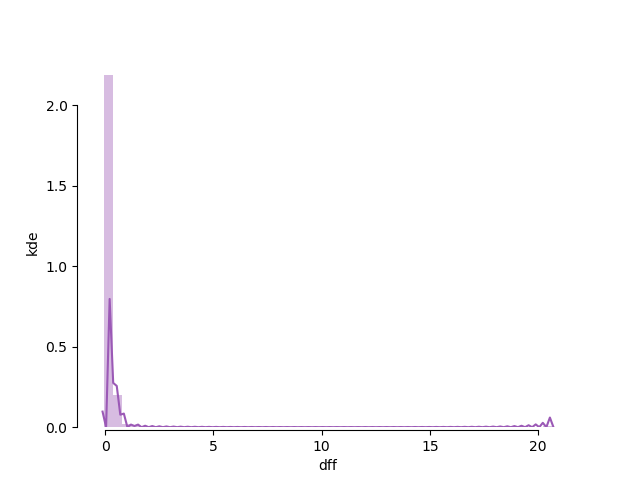

In [214]:
#fig, ax = pl.subplots()
#ax = hist_roi_stat(estats.gdf, metric='dff', roi_list=roi_list, ax=ax)


# Set output summary stats dir

In [215]:
summarydir = glob.glob(os.path.join(rootdir, exp.animalid, exp.session, exp.fov, exp.name,
                           'traces', '%s*' % exp.traceid, 'summary_stats', responsive_test))[0]

print(summarydir)

/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_0a550d_traces001_fa76b6_traces001_686258_traces001_2b2900_traces001_f43949/summary_stats/nstds


In [216]:
data_identifier = '|'.join([exp.animalid, exp.session, exp.fov, exp.traceid, '%s-%i' % (responsive_test, responsive_thr)])
print data_identifier

JC083|20190512|FOV1_zoom2p0x|traces001|nstds-10


# Look at overall distN of responses

<IPython.core.display.Javascript object>


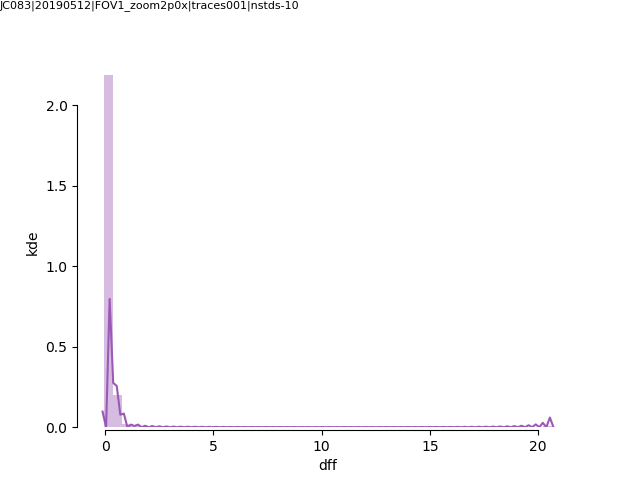

In [217]:
fig, ax = pl.subplots()
ax = hist_roi_stat(estats.gdf, metric='dff', roi_list=roi_list, ax=ax)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(summarydir, 'hist-avg-dff-best-cfg.png'))


# Load tuning fits

In [218]:
# Get responsivity stats:
responsive_test = 'nstds'
responsive_thr = 10
n_stds = 2.5

# Tuning params
n_bootstrap_iters = 1000
n_resamples = 20
n_intervals_interp = 3
min_cfgs_above = 2

In [219]:
create_new = False
plot_rois = False
goodness_thr = 0.66
n_processes = 8

In [220]:
bootresults, fitparams = exp.get_tuning(create_new=create_new, n_processes=n_processes,
                                           responsive_test=responsive_test, responsive_thr=responsive_thr,
                                           n_stds=n_stds, min_cfgs_above=min_cfgs_above,
                                           n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples,
                                           n_intervals_interp=n_intervals_interp, make_plots=False)


...getting OSI results: fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
Loading existing fits.


#### Test fit quality with goodness-of-fit metric

In [221]:
goodness_thr = 0.4

In [222]:
rmetrics, goodrois = exp.evaluate_fits(bootresults, fitparams, goodness_thr=goodness_thr, rootdir=rootdir, make_plots=False)
print(rmetrics.shape)

Loading existing fits.
169 cells fit at least 1 tuning curve.
42 cells have good fits (thr >= 0.40)
(42, 11)


In [223]:
rmetrics.shape

(42, 11)

In [224]:
#fitdf['preferred_theta'] = fitdf['preferred_theta'] % 360.

In [225]:
rmetrics.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof
0,0.445578,0.067964,0.025867,-0.001929,0.028781,33.075967,141.796430,0.798012,0.0,0.779484,0.630493
2,0.201446,0.150288,0.168604,-0.002935,0.252796,48.383070,60.978375,0.783433,2.0,0.571069,0.477606
4,0.241959,0.252062,0.057580,-0.010648,0.105269,46.433930,10.138344,0.891218,4.0,0.733201,0.698051
6,0.060890,0.097244,0.015789,0.003115,0.039671,77.094838,154.060112,0.849089,6.0,0.823150,0.677266
7,0.338574,0.128353,0.063199,0.036374,0.100232,24.475371,63.656706,0.819013,7.0,0.822805,0.639730


# Set output dir to tuning dir

In [227]:
tuningdir = fitparams['directory']
print tuningdir

/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_0a550d_traces001_fa76b6_traces001_686258_traces001_2b2900_traces001_f43949/tuning/fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Visualize tuning characteristics of well-fit neurons

In [228]:

fit_desc = os.path.split(fitparams['directory'])[-1]
data_identifier = '|'.join([exp.animalid, exp.session, exp.fov, exp.traceid, fit_desc])


In [229]:
df = rmetrics[rmetrics['cell'].isin(goodrois)]
print(df.shape)

(42, 11)


In [230]:
df.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof
0,0.445578,0.067964,0.025867,-0.001929,0.028781,33.075967,141.796430,0.798012,0.0,0.779484,0.630493
2,0.201446,0.150288,0.168604,-0.002935,0.252796,48.383070,60.978375,0.783433,2.0,0.571069,0.477606
4,0.241959,0.252062,0.057580,-0.010648,0.105269,46.433930,10.138344,0.891218,4.0,0.733201,0.698051
6,0.060890,0.097244,0.015789,0.003115,0.039671,77.094838,154.060112,0.849089,6.0,0.823150,0.677266
7,0.338574,0.128353,0.063199,0.036374,0.100232,24.475371,63.656706,0.819013,7.0,0.822805,0.639730


#### Sort by DSI

In [231]:
def rois_sortby(fitdf, sort_by='DSI', plot_metric='theta_pref', roi_list=None, descending=True):
    if roi_list is not None:
        df = fitdf[fitdf['cell'].isin(roi_list)]
    else:
        df = fitdf.copy()
    
    if 'theta' in sort_by:
        dsi_values = df.groupby(['cell'])[plot_metric].apply(np.deg2rad).apply(spstats.circmean).apply(np.rad2deg)
    elif 'rad' in sort_by:
        dsi_values = df.groupby(['cell'])[plot_metric].apply(np.deg2rad).apply(spstats.circmean).apply(np.rad2deg)
    else:
        dsi_values = df.groupby(['cell']).mean()[sort_by]
    if descending:
        dsi_sorted_ixs = np.argsort(dsi_values).values[::-1] #Sort from biggest to smallest
    else:
        dsi_sorted_ixs = np.argsort(dsi_values).values #Sort from smallest to biggest
    rsort_by_dsi = np.array(dsi_values.index.tolist())[dsi_sorted_ixs]

    return rsort_by_dsi


In [232]:
def split_even_odd_trials(bootresults, rsort_by):
    evens = []
    odds = []
    for roi in rsort_by:
        evens_t = np.vstack([bootr['data']['responses'][0::2].mean().values for stimparam, bootr in bootresults[roi].items()]).mean(axis=0)
        odds_t = np.vstack([bootr['data']['responses'][1::2].mean().values for stimparam, bootr in bootresults[roi].items()]).mean(axis=0)
        evens.append(evens_t)
        odds.append(odds_t)
    evens = np.array(evens)
    odds = np.array(odds)
    return evens, odds

In [233]:
def plot_even_odd_trials(evens, odds, rsort_by, cmap='inferno', tested_values=None):

    fig, axes = pl.subplots(1,2, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.85, .3, .03, .4])
    vmin = min([evens.min(), odds.min()])
    vmax = max([evens.max(), odds.max()])

    sns.heatmap(evens, ax=axes[0], cbar=True, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax, cmap=cmap)
    axes[0].set_title('evens')
    axes[0].set_xticklabels(tested_values, rotation=45)

    sns.heatmap(odds, ax=axes[1], cbar=0, vmin=vmin, vmax=vmax, cbar_ax=None, cmap=cmap)
    axes[1].set_title('odds')
    axes[1].set_xticklabels(tested_values, rotation=45)
    axes[1].tick_params(labelsize=8)

    axes[0].set_ylabel('cell')
    axes[0].set_yticks(np.arange(0, len(rsort_by))) 
    axes[0].set_yticklabels([int(i) for i in rsort_by], rotation=45) #(tested_values, rotation=45)
    axes[0].tick_params(axis='y', labelsize=6)
    cbar_ax.set_title(response_type)

    pl.subplots_adjust(wspace=0.05, right=0.80)
    
    return fig

# Compare even and odd trials for cells with good tuning fits

In [234]:
tested_values = np.array(estats.sdf['ori'].unique().astype(float))
cmap = 'inferno'

<IPython.core.display.Javascript object>


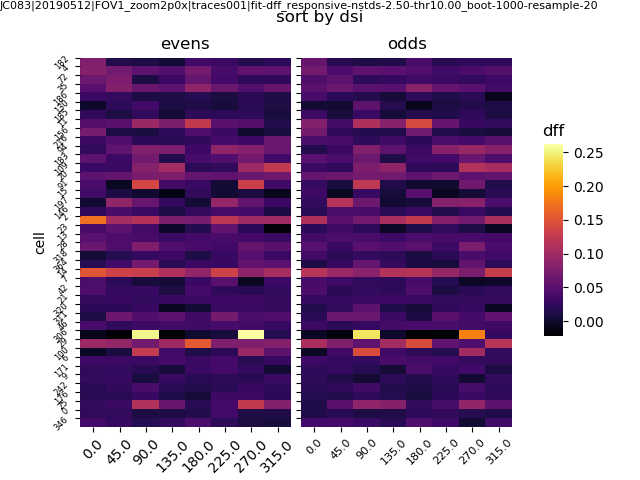

gof-0.40_tuning-on-evens-vs-odd-trials_sort-by-dsi


In [235]:
# Sort by DSI
sort_by = 'dsi'
rsort_by = rois_sortby(df, sort_by=sort_by, plot_metric='theta_pref', roi_list=None, descending=True)
evens, odds = split_even_odd_trials(bootresults, rsort_by)

fig = plot_even_odd_trials(evens, odds, rsort_by, cmap=cmap, tested_values=tested_values)
fig.suptitle('sort by %s' % sort_by)

label_figure(fig, data_identifier)

figname = 'gof-%.2f_tuning-on-evens-vs-odd-trials_sort-by-%s' % (goodness_thr, sort_by)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
print figname

<IPython.core.display.Javascript object>


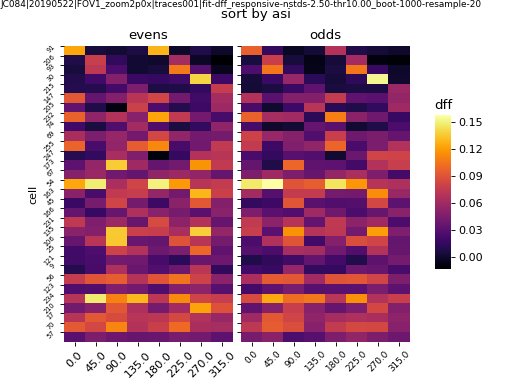

gof-0.66_tuning-on-evens-vs-odd-trials_sort-by-asi


In [113]:
# Sort by ASI
sort_by = 'asi'
rsort_by = rois_sortby(df, sort_by=sort_by, plot_metric='theta_pref', roi_list=None, descending=True)
evens, odds = split_even_odd_trials(bootresults, rsort_by)

fig = plot_even_odd_trials(evens, odds, rsort_by, cmap=cmap, tested_values=tested_values)
fig.suptitle('sort by %s' % sort_by)

label_figure(fig, data_identifier)

figname = 'gof-%.2f_tuning-on-evens-vs-odd-trials_sort-by-%s' % (goodness_thr, sort_by)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
print figname

#### Sort by preferred theta

<IPython.core.display.Javascript object>


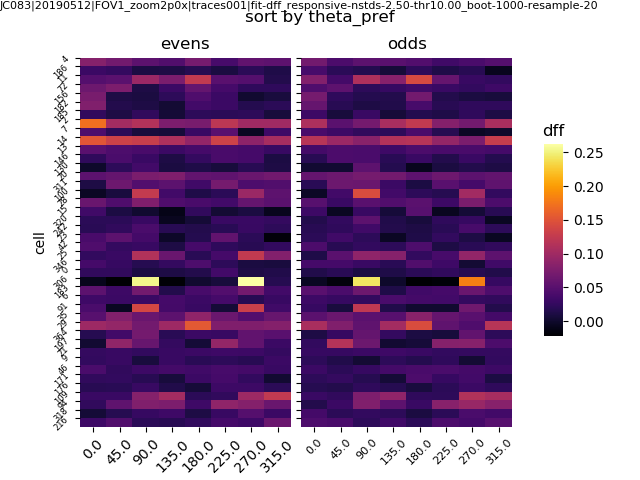

gof-0.40_tuning-on-evens-vs-odd-trials_sort-by-theta_pref


In [236]:
# Sort by DSI
sort_by = 'theta_pref'
rsort_by = rois_sortby(df, sort_by=sort_by, plot_metric='theta_pref', roi_list=None, descending=False)
evens, odds = split_even_odd_trials(bootresults, rsort_by)

fig = plot_even_odd_trials(evens, odds, rsort_by, cmap=cmap, tested_values=tested_values)
fig.suptitle('sort by %s' % sort_by)

label_figure(fig, data_identifier)

figname = 'gof-%.2f_tuning-on-evens-vs-odd-trials_sort-by-%s' % (goodness_thr, sort_by)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
print figname




# figname= '%s_tuning-on-evens-vs-odd-iters_sort-by-preferredtheta' % filter_str
# pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
# figname

# Look at distN of each metric

<IPython.core.display.Javascript object>


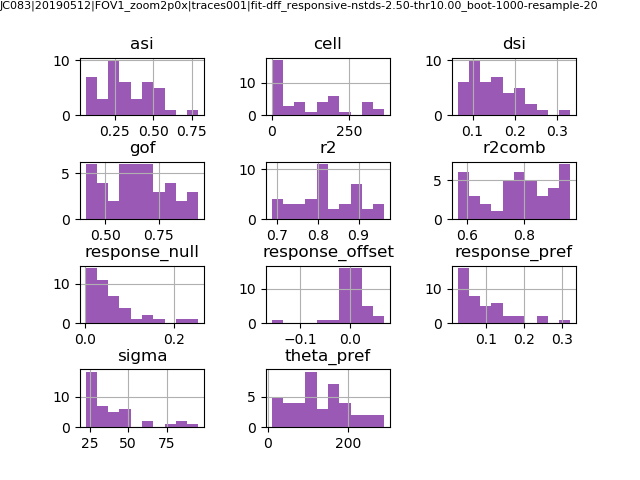

hist-each-param_gof-0.40


In [237]:

fig = rmetrics.hist()
pl.subplots_adjust(hspace=0.8, wspace=0.5)

label_figure(fig[0][0].figure, data_identifier)

figname = 'hist-each-param_gof-%.2f' % goodness_thr
print(figname)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))

# Compare metrics pair-wise

In [238]:
from pandas.plotting import scatter_matrix


<IPython.core.display.Javascript object>


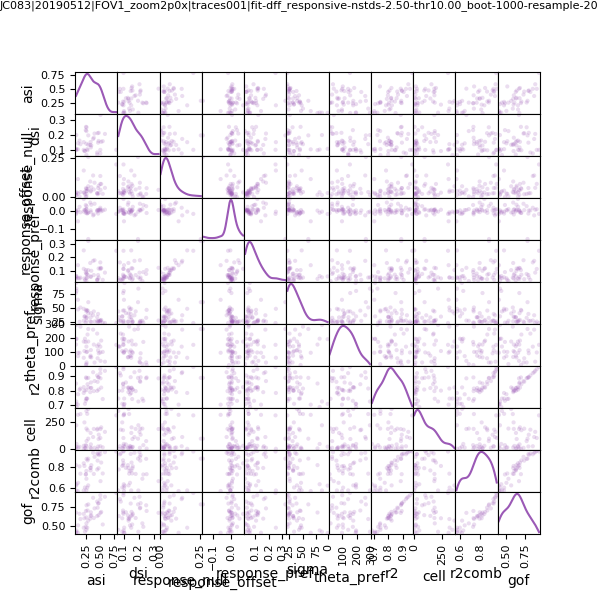

scatter-matrix_gof-0.40


In [239]:

fig = scatter_matrix(rmetrics, alpha=0.2, figsize=(6, 6), diagonal='kde')

label_figure(fig[0][0].figure, data_identifier)
figname = 'scatter-matrix_gof-%.2f' % goodness_thr
print(figname)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))

# Find closest matching tested theta to plot histogram of preferred angles

In [240]:
from collections import Counter
from matplotlib import patches

def hist_gratings_stats(tuningdf, all_categories, colorvals, variable='pref_theta', ax=None,
                        thresh=0.33, ori_metric='ASI', show_selective=False):
        
    best_ori_vals = tuningdf[variable]
    best_ori_vals_selective = tuningdf[tuningdf[ori_metric] >= thresh][variable]
    
    ori_counts_all = Counter(best_ori_vals)
    if all_categories is not None:
        for catg in all_categories:
            if catg not in ori_counts_all:
                ori_counts_all[catg] = 0
                
    ori_counts_selective = Counter(best_ori_vals_selective)
    for ori in ori_counts_all.keys():
        if ori not in ori_counts_selective.keys():
            ori_counts_selective[ori] = 0
   
    bar_palette = colorvals.as_hex()
    
    if ax is None:
        fig, ax = pl.subplots()
    
    sns.barplot(sorted(ori_counts_all.keys()), [ori_counts_all[c] for c in sorted(ori_counts_all.keys())], palette=bar_palette, ax=ax)
    ax.tick_params(axis='x', which='both', length=0)

    if show_selective:    
        ax2 = ax.twinx()
        sns.barplot(sorted(ori_counts_all.keys()), [ori_counts_selective[c] for c in sorted(ori_counts_all.keys())], palette=bar_palette, ax=ax2)
        ax2.set_ylim(ax.get_ylim())
        hatch = '//' #itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])
        for i, bar in enumerate(ax2.patches):
            bar.set_hatch(hatch)
        ax2.set_yticklabels([])
        ax2.tick_params(axis='both', which='both', length=0)
    
        hatch1 = patches.Patch( facecolor='white', hatch=r'\\\\',label='%s > %.2f' % (ori_metric, thresh))
        ax2.legend(handles = [hatch1], loc=1)
        
    sns.despine(trim=True, offset=4)
        
    return ax

In [241]:
tested_values

array([  0.,  45.,  90., 135., 180., 225., 270., 315.])

In [242]:
tested_thetas = list(tested_values.copy())
#tested_thetas.append(360)

tested_thetas = np.array(tested_thetas)

rmetrics['theta_tested'] = [tested_thetas[np.where(np.abs(t-tested_thetas)== np.min(np.abs(t-tested_thetas)))[0][0]] % 360. \
                            for t in rmetrics['theta_pref']]
#tested_thetas = tested_thetas[0:-1]

In [243]:
for t in rmetrics['theta_pref']:
    closest_match = int(tested_thetas[np.where(np.abs(t-tested_thetas)== np.min(np.abs(t-tested_thetas)))])
    print round(t,2), closest_match

141.8 135
60.98 45
10.14 0
154.06 135
63.66 45
195.05 180
27.37 45
72.52 90
66.6 45
102.18 90
96.02 90
192.03 180
112.49 90
139.27 135
101.13 90
174.86 180
172.48 180
114.84 135
195.31 180
27.94 45
155.05 135
263.52 270
98.38 90
259.2 270
92.75 90
75.94 90
33.5 45
224.65 225
231.23 225
39.09 45
153.89 135
57.43 45
16.7 0
181.87 180
291.73 270
108.47 90
152.06 135
96.39 90
280.09 270
104.24 90
139.94 135
175.46 180


In [244]:
tested_thetas

array([  0.,  45.,  90., 135., 180., 225., 270., 315.])

In [245]:
int(tested_thetas[np.where(np.abs(t-tested_thetas)== np.min(np.abs(t-tested_thetas)))])

180

<IPython.core.display.Javascript object>


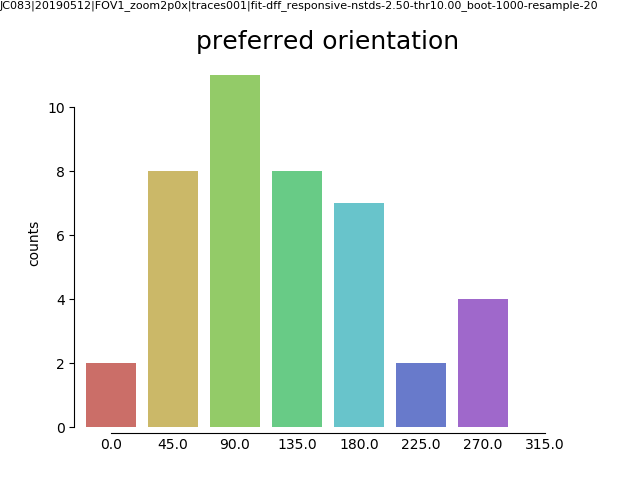

hist-tested-oris_gof-0.40


In [246]:


cmap = 'hls'
noris = len(tested_values)

fig, ax = pl.subplots()
colorvals = sns.color_palette(cmap, noris) # len(gratings_sconfigs))
#show_selective = False if filter_gof else True
if tested_thetas.shape[0] > 0:
    hist_gratings_stats(rmetrics, tested_thetas, colorvals, ax=ax, variable='theta_tested',
                       thresh=goodness_thr, ori_metric='gof', show_selective=False)
ax.set_title('preferred orientation', fontsize=18)
ax.set_ylabel('counts')
        
    
    
label_figure(fig, data_identifier)
figname = 'hist-tested-oris_gof-%.2f' % goodness_thr
print(figname)
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))


# Preferred axis polar

<IPython.core.display.Javascript object>


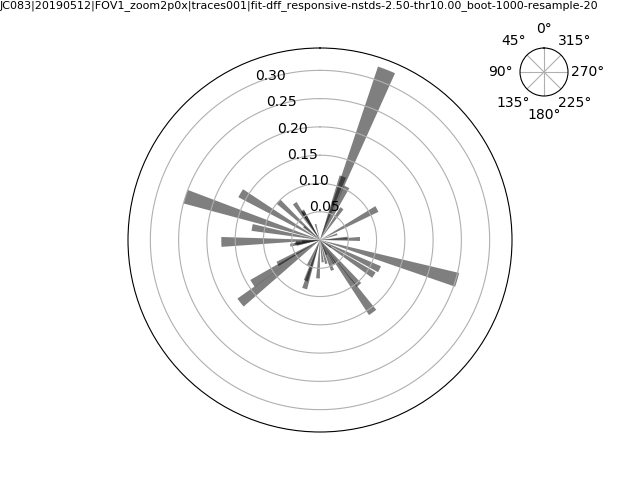

polar-preferred-pris_gof-0.40


In [247]:
fig = pl.figure()
fig.patch.set_alpha(1)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
#lbs = []

radii = rmetrics['response_pref']
thetas = rmetrics['theta_pref']

bars = ax.bar(thetas, radii, width=.1, bottom=0.0, color='k', alpha=0.5)
for r,bar in zip(radii, bars):
    bar.set_alpha(0.5)
ax.set_theta_zero_location("N")
ax.set_xticks([])
#lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

#legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
#                  for visual_area, lb in zip(visual_areas, lbs)]
#leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

label_figure(fig, data_identifier)
figname = 'polar-preferred-pris_gof-%.2f' % goodness_thr
print(figname)
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))


In [42]:
rmetrics.shape

(47, 12)

In [191]:
tuningdir

u'/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3b241d_traces001_ebfa5b_traces001_f5e412_traces001_f07566/tuning/fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

# Plot preferred ori on fov

In [248]:
from pipeline.python.rois import utils as roiutils

In [249]:
S = util.Session(animalid, session, fov)

[JC083] 20190512 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190512 | FOV1_zoom2p0x)
... Getting screen info


In [250]:
roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, 'gratings', traceid=traceid)
print roiid

rois001


In [251]:
masks, zimg = S.load_masks(roiid)
masks = np.swapaxes(masks, 0, 2)
masks = np.swapaxes(masks, 1, 2)

In [252]:
masks.shape

(366, 512, 512)

<IPython.core.display.Javascript object>


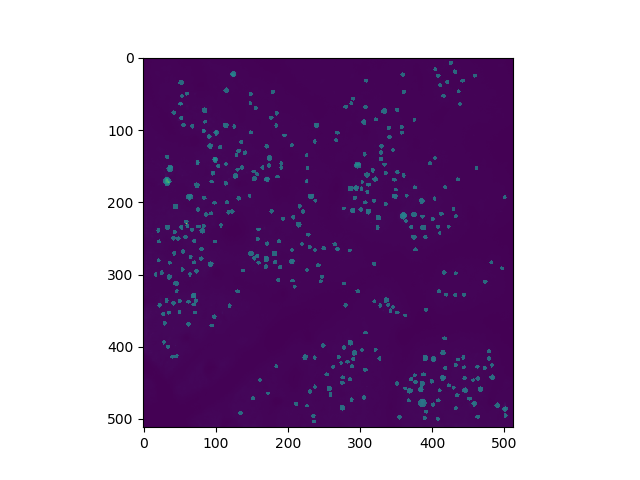

In [253]:
pl.figure()
pl.imshow(zimg)
pl.imshow(masks.sum(axis=0), alpha=0.7)

# Set colormap

In [254]:
def mask_rois(masks, value_array, mask_thr=0.1):
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)
    
    #masked = np.ma.masked_where(mask == 0, mask)

    
    value_mask =  np.ones(dims)*-100
    for rid in value_array.index.tolist():
        value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask


In [255]:
print len(tested_thetas)
ori_colors = sns.color_palette('cubehelix', n_colors=len(tested_thetas))

8


In [256]:
rois_plot = np.array(rmetrics.index.tolist())
#masks_plot = masks[rois_plot, :, :]
masks_values = rmetrics['theta_tested']
value_mask = mask_rois(masks, masks_values)
value_mask.shape
ori_mask = value_mask.copy()
ori_mask[value_mask==-100]=np.nan

In [257]:
value_mask

array([[-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       ...,
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.]])

<IPython.core.display.Javascript object>


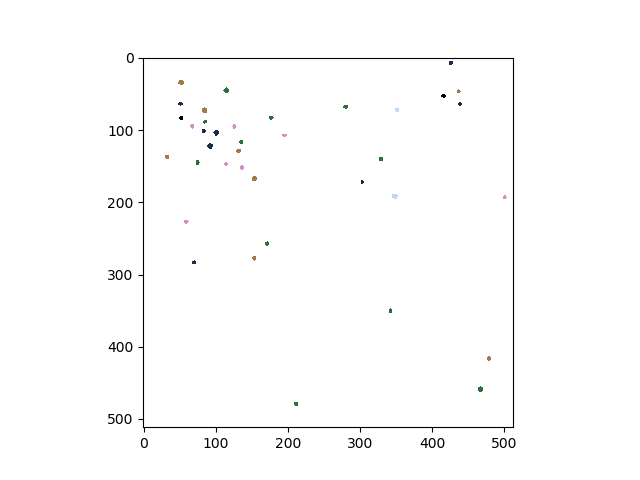

In [258]:
pl.figure()
pl.imshow(ori_mask, cmap='cubehelix')

<IPython.core.display.Javascript object>


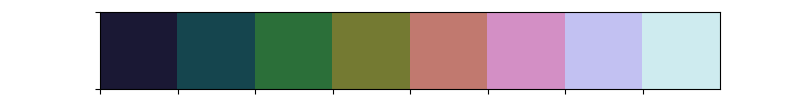

In [163]:
sns.palplot(ori_colors)